CNN

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
device=torch.device('cpu')

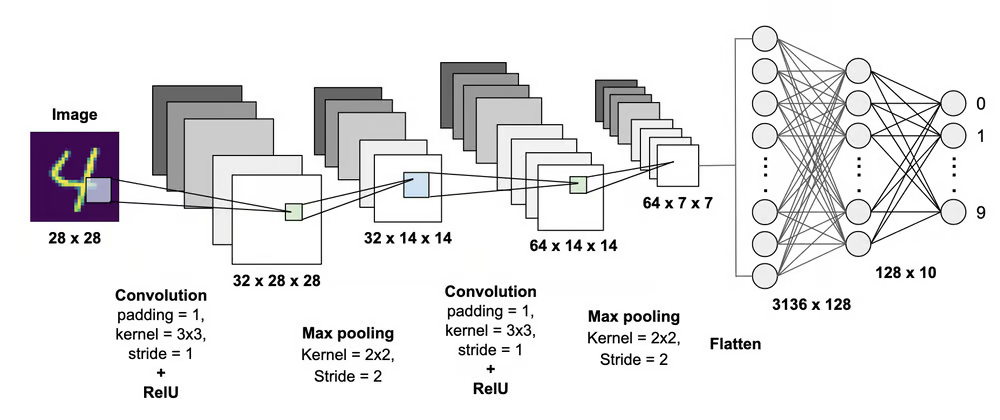

#for convolution layer
Output Dimension=((Input Dimension+2×Padding−Kernel Size) / Stride)+1



Output Dimension= (28+2×1−3 / 1 ) + 1=28

#for pooling layer
Output Dimension=((Input Dimension−Kernel Size) / Stride)+1

max pooling with kernel_size=2 and stride=2 halves the dimensions:


Output Dimension= 
(28-2 / 2 ) + 1=14

In [4]:
#in channels - grayscale - 1 , color - 3
#out_channels (feature maps): This parameter determines how many output channels the convolutional layer will produce.
#kernel_size=(3, 3): This defines the size of the convolutional kernel (A.K.A filter). filters extract features from data(image)
#feature maps are outputs are the outputs that represent features detected by the filters
#stride=(1, 1): The stride determines how many pixels the filter moves along the input image.
#padding=(1, 1): Padding is added to the borders of the input image before applying the convolution.

#maxpool2d will reduce the max element from the window(kernel).
#returns 28X28 to 14X14 to 7X7 (since pooling is applied twice)

#for the linear layer we are using 16*7*7 because we have 16 out channels from pooling we get 7*7

class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool=nn.MaxPool2d(kernel_size=(2,2), stride =(2,2))
        self.conv2=nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.fc1=nn.Linear(16*7*7, num_classes)

    def forward(self, x):
        x=self.conv1(x)
        x=F.relu(x)
        x=self.pool(x)
        x=self.conv2(x)
        x=F.relu(x)
        x=self.pool(x)
        x=x.reshape(x.shape[0], -1)
        x=self.fc1(x)
        return x
        


In [5]:
learning_rate=0.001
batch_size=64
num_epochs=5

In [6]:
train_dataset= datasets.MNIST(root='dataset/', train=True , transform=transforms.ToTensor() , download=True)
train_loader=DataLoader(dataset=train_dataset , batch_size=batch_size , shuffle= True)
test_dataset=datasets.MNIST(root='dataset/', train=False , transform=transforms.ToTensor() , download=True)
test_loader=DataLoader(dataset=test_dataset , batch_size=batch_size , shuffle= False)


In [7]:
#initialize
model=CNN().to(device)

criterion= nn.CrossEntropyLoss() 
optimizer=optim.Adam(model.parameters() , lr=learning_rate)      

In [8]:
#model training

for epoch in range(num_epochs):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data=data.to(device=device)
        targets=targets.to(device=device)

        #forward
        outputs=model(data)                #produces outputs , out.shape = [64,10] , for each training ex give 10 values(probs of 10 classes)
        loss=criterion(outputs,targets)    #loss func , find loss btw models predictions (outputs) and true labels(targets)
        #already reshaped into [64, 784]

        losses.append(loss.item())
        
        #backward
        optimizer.zero_grad()              #Before backpropagation, you need to zero out (reset) the gradients of all the parameters.
        loss.backward()                    #the gradients of the loss are computed
        
        #gradient descent or adam step
        optimizer.step()                   #the optimizer adjusts the weights and biases (i.e., the parameters) based on computed gradients
    
    print(f"Loss average over epoch {epoch} is {sum(losses)/len(losses):.3f}")

In [9]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('checking accuracy on training data')
    else:
        print('checking accuracy on test data')

    num_correct=0
    num_samples=0 
    model.eval()  
  
    with torch.no_grad():           #torch.no_grad() is a context manager that disables gradient calculation
        for x, y in loader: 
            x=x.to(device=device)
            y=y.to(device=device)

            scores=model(x)

            _, predictions = scores.max(dim=1)     
                                                
            num_correct += (predictions==y).sum()    
            num_samples += predictions.size(0)       


        print(f'got {num_correct} / {num_samples} with acuuracy {float(num_correct) / float(num_samples) * 100:.2f}')

    model.train()   

In [58]:
check_accuracy(train_loader,model)
check_accuracy(test_loader,model)

checking accuracy on training data
got 59054 / 60000 with acuuracy 98.42
checking accuracy on test data
got 9815 / 10000 with acuuracy 98.15


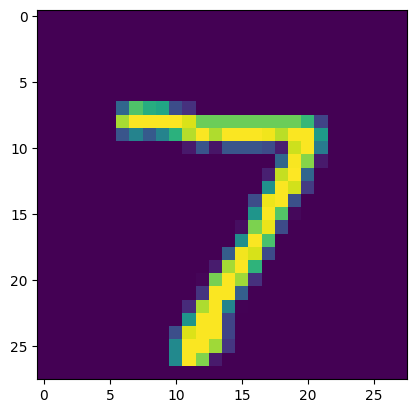

In [52]:
import matplotlib.pyplot as plt

plt.imshow(test_dataset[0][0].reshape(28,28))
plt.show()


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
def show_random_image_and_prediction(model, test_loader, device):

    model.eval() # Set the model in evaluation mode

    test_batches = list(test_loader)
    random_batch = random.choice(test_batches)
    images, labels = random_batch
    
    rand_idx=np.random.randint(64)
     
    image = images[rand_idx]    #dimension is (1,28,28) , it is the randomly chosen image
    actual_label = labels[rand_idx].item()
    
    # Reshape the image to (28, 28) for visualization (since it's a grayscale image)
    image_for_display = image.squeeze()  # Remove the channel dimension, from (1, 28, 28) to (28, 28)
    
    image = image.unsqueeze(0).to(device)    #the model expects (1,1,28,28) since model has been trained on (64,1,28,28)
    #so we unsqeeze(add dimension at dim=0) 
    
    with torch.no_grad():
        prediction = model(image)
        predicted_label = prediction.argmax(1).item()
    
    plt.imshow(image_for_display)
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.show()

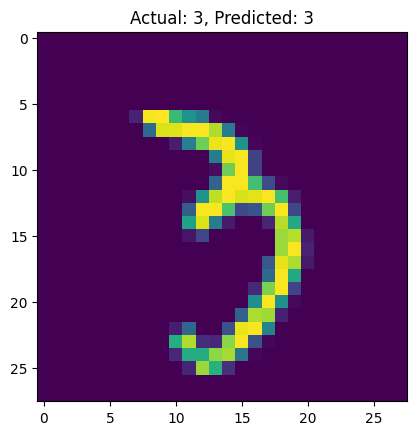

In [57]:
show_random_image_and_prediction(model, test_loader, device)

In [ ]:
# PATH = './mnist_cnn'  # Local file path for the entire model
# torch.save(model, PATH)  # Save the entire model

In [60]:
scripted_model = torch.jit.script(model)  # Script the model
torch.jit.save(scripted_model, 'mnist_cnn.pth' )  # Save scripted model